In [1]:
import pyNUISANCE as pn
rf = pn.RecordFactory()
hepdata_rec = rf.make_record({"type":"hepdata", "recordpath":"/root/software/NUISANCEMC/neutrino_data/data/T2K/CrossSection/CC0Pi_CO_TKI_2024/submission-999999"})

Welcome to JupyROOT 6.30/04


In [2]:
ana = hepdata_rec.analysis("cross_section_c")
probe_flux_count = ana.get_probe_flux(False)
probe_flux_count_density = ana.get_probe_flux(True)

pn.convert.ROOT.write_TH1("flux_for_t2k_CC0Pi_CO_TKI.root",
                          "flux_count", probe_flux_count.spectrum,False,"RECREATE")
pn.convert.ROOT.write_TH1("flux_for_t2k_CC0Pi_CO_TKI.root",
                          "flux_count_density", probe_flux_count_density.spectrum,False,"UPDATE")

print(probe_flux_count.probe_pdg)
print(probe_flux_count.source)
[ str(tgt) for tgt in ana.get_target() ]

14
/root/software/NUISANCEMC/eventinput/data/hepdata-sandbox/1722947187/HEPData-1722947187-v1/t2kflux_2020_minus250ka_nd280_runcond.yaml


['1000060120']

In [3]:
%%bash
# only generate if we haven't already
if [ ! -e events_for_t2k_CC0Pi_CO_TKI.C.hepmc3.gz ]; then
    neut-quickstart -t C -s numu \
                -f flux_for_t2k_CC0Pi_CO_TKI.root,flux_count \
                -n 200000 \
                -o events_for_t2k_CC0Pi_CO_TKI.C.hepmc3.gz
fi
if [ ! -e events_for_t2k_CC0Pi_CO_TKI.O.hepmc3.gz ]; then
    neut-quickstart -t O -s numu \
                -f flux_for_t2k_CC0Pi_CO_TKI.root,flux_count \
                -n 200000 \
                -o events_for_t2k_CC0Pi_CO_TKI.O.hepmc3.gz
fi

In [4]:
neut_events_C = pn.EventSource("events_for_t2k_CC0Pi_CO_TKI.C.hepmc3.gz")
if not neut_events_C:
    print("Failed to read file")

neut_events_O = pn.EventSource("events_for_t2k_CC0Pi_CO_TKI.O.hepmc3.gz")
if not neut_events_O:
    print("Failed to read file")

In [5]:
ana = hepdata_rec.analysis("cross_section_co")
comparison_CO = ana.process([neut_events_C, neut_events_O])

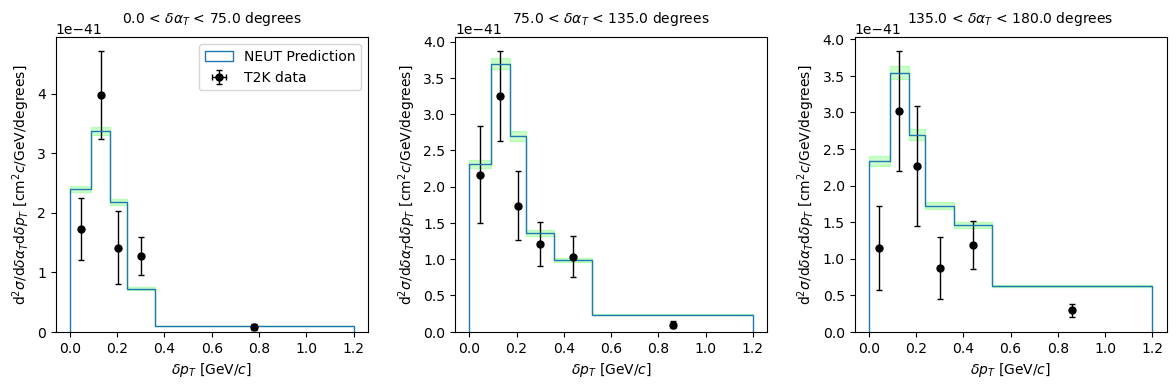

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3, figsize=(12,4))

d_x_bin_centers = pn.Binning.get_bin_centers1D(comparison_CO.data[0].project(0).binning.bins)
d_x_bin_edges = pn.Binning.get_bin_edges1D(comparison_CO.data[0].project(0).binning.bins)

for i in range(len(d_x_bin_centers)):
    d_slice = comparison_CO.data[0].slice(0,d_x_bin_centers[i])
    p_slice = comparison_CO.predictions[0].slice(0,d_x_bin_centers[i])
    
    d_slice.mpl().data_hist(plot_axis=axes[i], label="T2K data")
    p_slice.mpl().hist(histtype="step", plot_axis=axes[i], errorband_color="#0F03", label="NEUT Prediction")

    x_proj_prettyname = ana.get_projections()[0].prettyname
    x_proj_unit = ana.get_projections()[0].units
    
    axes[i].text(0.5,1.05,f"{d_x_bin_edges[i]} < {x_proj_prettyname} < {d_x_bin_edges[i+1]} {x_proj_unit}",
                horizontalalignment="center",transform = axes[i].transAxes)
    
    if not i:
        axes[i].legend()

fig.tight_layout()
fig.show()

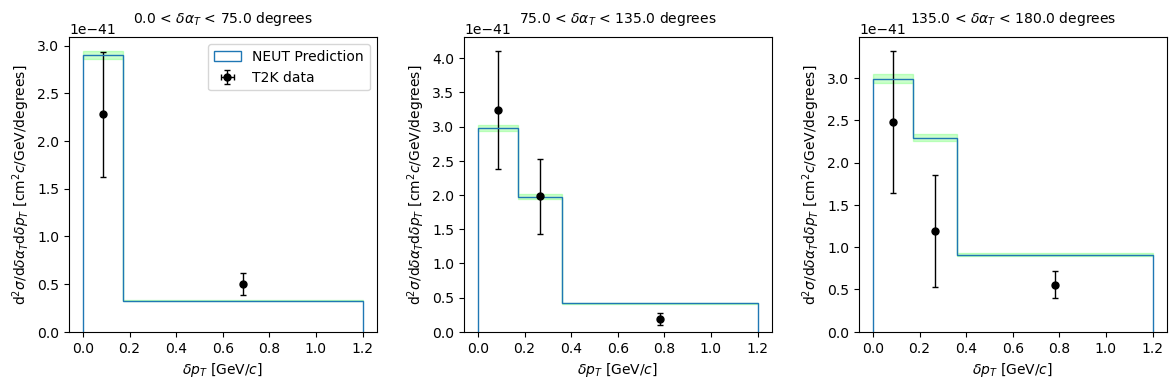

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3, figsize=(12,4))

d_x_bin_centers = pn.Binning.get_bin_centers1D(comparison_CO.data[1].project(0).binning.bins)
d_x_bin_edges = pn.Binning.get_bin_edges1D(comparison_CO.data[1].project(0).binning.bins)

for i in range(len(d_x_bin_centers)):
    d_slice = comparison_CO.data[1].slice(0,d_x_bin_centers[i])
    p_slice = comparison_CO.predictions[1].slice(0,d_x_bin_centers[i])

    d_slice.mpl().data_hist(plot_axis=axes[i], label="T2K data")
    p_slice.mpl().hist(histtype="step", errorband_color="#0F03", plot_axis=axes[i], label="NEUT Prediction")

    x_proj_prettyname = ana.get_projections()[0].prettyname
    x_proj_unit = ana.get_projections()[0].units
    
    axes[i].text(0.5,1.05,f"{d_x_bin_edges[i]} < {x_proj_prettyname} < {d_x_bin_edges[i+1]} {x_proj_unit}",
                horizontalalignment="center",transform = axes[i].transAxes)
    
    if not i:
        axes[i].legend()

fig.tight_layout()
fig.show()

In [8]:
comparison_CO.likelihood()

117.74709396432756